### Boiler Plate Code

In [3]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
words = open('names.txt', 'r').read().splitlines()
print(len(words))
print(max(len(w) for w in words))
print(words[:8])

32033
15
['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']


In [10]:
# build vocab
chars = sorted(list(set(''.join(words))))
stoi = {ch:i+1 for i,ch in enumerate(chars)}
stoi['.'] = 0
itos = {i:ch for ch,i in stoi.items()}
vocab_size = len(stoi)
print(vocab_size)

27


In [15]:
# build dataset
block_size = 3

def build_dataset(words):
    X, Y = [], []
    for word in words:
        context = [0]*block_size
        for w in word + '.':
            ix = stoi[w]
            X.append(context)
            Y.append(ix)
            
            context = context[1:] + [ix]
            
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y
        

In [17]:
import random
random.seed(42)
random.shuffle(words)

n1 = int(0.8*len(words))
n2 = int(0.9*len(words))


Xtr, Ytr = build_dataset(words[:n1])
Xval, Yval = build_dataset(words[n1:n2])
Xtst, Ytst = build_dataset(words[n2:])

torch.Size([182580, 3]) torch.Size([182580])
torch.Size([22767, 3]) torch.Size([22767])
torch.Size([22799, 3]) torch.Size([22799])


### Action Time
1. intialize all parameters
2. perform manual forward and backward pass
3. mathematically optimize the passes

In [60]:
# utility code, to compare manual gradients
def cmp(s, dt, t):
    ex = torch.all(dt == t.grad).item()
    app = torch.allclose(dt, t.grad)
    maxdiff = (dt - t.grad).abs().max().item()
    print(f'{s:15s} | exact: {str(ex):5s} | approximate: {str(app):5s} | maxdiff: {maxdiff}')

In [21]:
# Intialize all parameters
#  Note: initializating these parameters in non-standard ways
# because sometimes initializating with e.g. all zeros could
# mask an incorrect implementation of the backward pass.

n_embd = 10
n_hidden = 64

g = torch.Generator().manual_seed(2147483647)
C = torch.randn((vocab_size, n_embd) , generator=g)

# Layer 1
W1 = torch.randn((n_embd*block_size, n_hidden), generator=g)*(5/3)/((n_embd * block_size)**0.5)
b1 = torch.randn(n_hidden, generator=g)*0.1 # added for fun, else useless in batchnorm

# Layer 2
W2 = torch.randn((n_hidden, vocab_size), generator=g)*0.1
b2 = torch.randn(vocab_size, generator=g)*0.1

# BatchNorm Params
bngain = torch.randn((1, n_hidden))*0.1 + 1.0
bnbias = torch.randn((1, n_hidden))*0.1

In [22]:
parameters = [C, W1, b1, W2, b2, bngain, bnbias]
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True

4137


In [23]:
batch_size = 32
n = batch_size

ix = torch.randint(0, Xtr.shape[0], (batch_size, ), generator=g)
Xb, Yb = Xtr[ix], Ytr[ix]

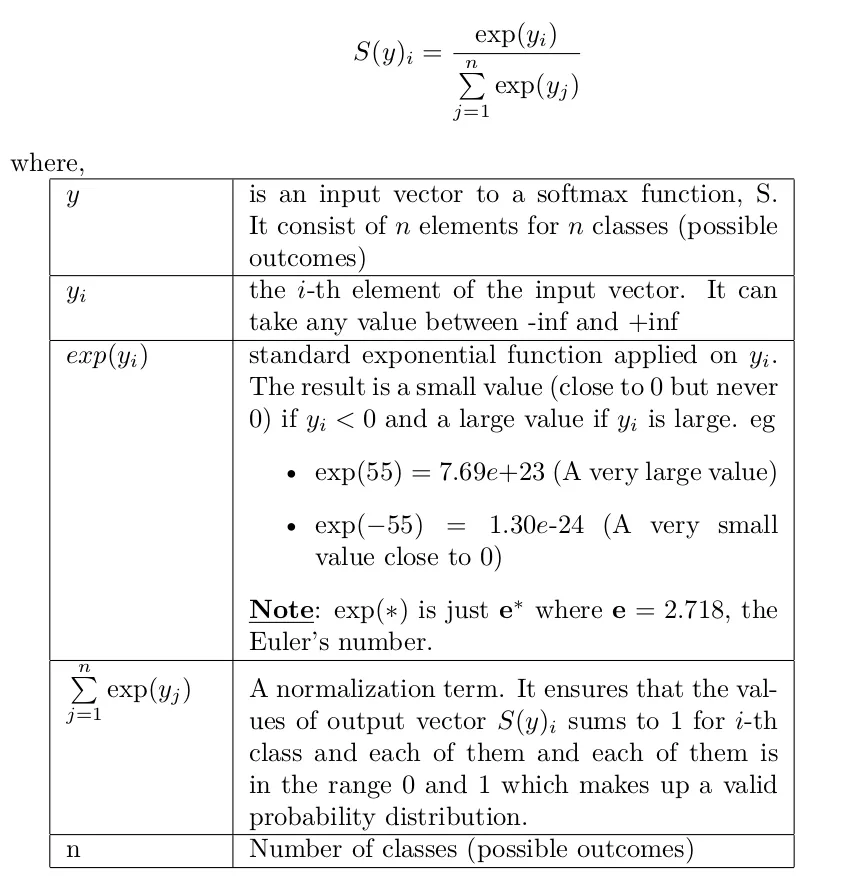
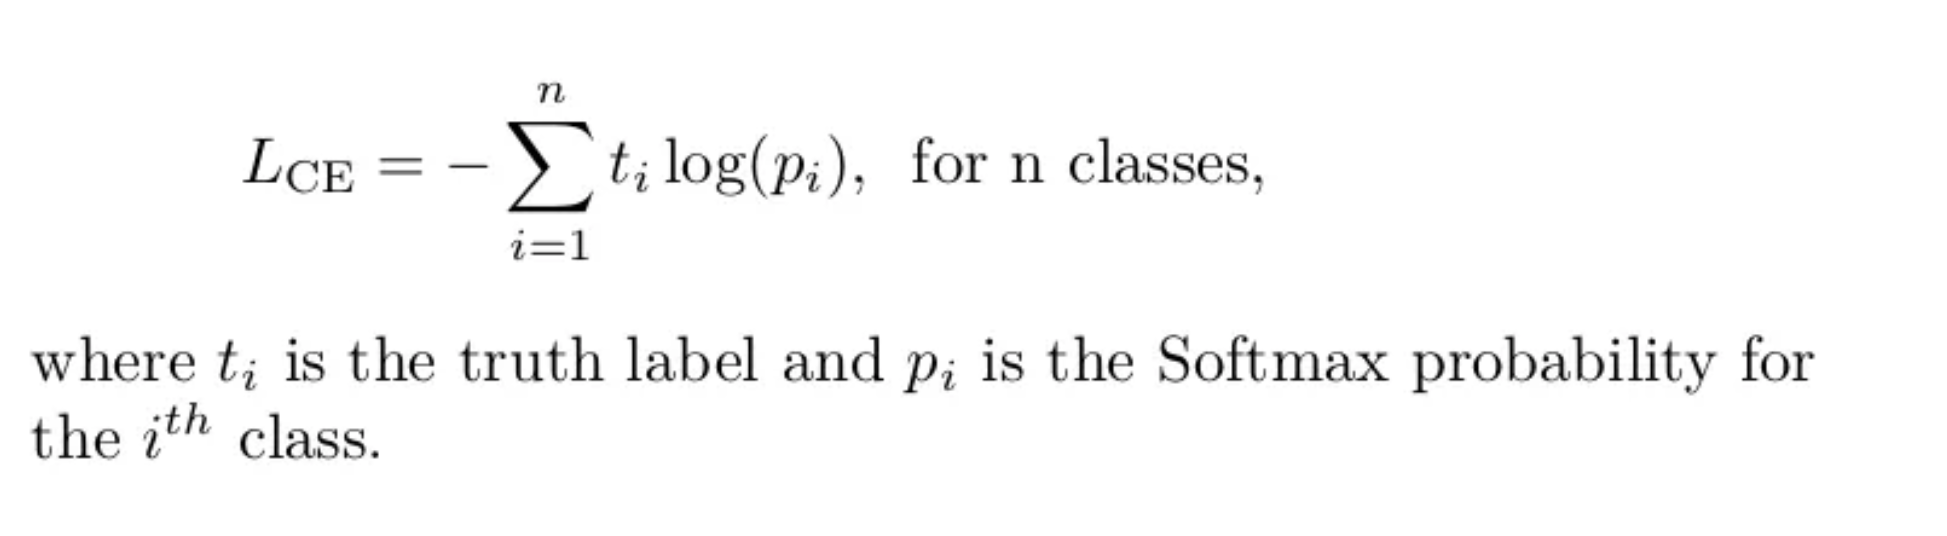

In [143]:
# Forward Pass
emb = C[Xb]
embcat = emb.view(emb.shape[0], -1)

# Linear Layer 1
hprebn = embcat @ W1 + b1

# BatchNorm Layer
bnmeani = 1/n*hprebn.sum(0, keepdim=True)
bndiff = hprebn - bnmeani
bndiff2 = bndiff**2
bnvar = 1/(n-1)*(bndiff2).sum(0, keepdim=True) # Bessel's correction (dividing by n-1, not n)
bnvar_inv = (bnvar + 1e-5)**-0.5
bnraw = bndiff * bnvar_inv
hpreact = bngain*bnraw + bnbias

# Non-Linear, hidden layer
h = torch.tanh(hpreact)

# Linear Layer 2
logits = h @ W2 + b2

# Cross Entropy Loss
logit_maxes = logits.max(1, keepdim=True).values
norm_logits = logits - logit_maxes # subtract max for numerical stability
counts = norm_logits.exp()
counts_sum = counts.sum(1, keepdims=True)
counts_sum_inv = counts_sum**-1
probs = counts * counts_sum_inv
logprobs = probs.log()
loss = -logprobs[range(n), Yb].mean()


In [144]:
# Backward Pass: Pytorch
for p in parameters:
    p.grad = None
    
for t in [logprobs, probs, counts_sum_inv, counts_sum, counts, norm_logits, logit_maxes, logits, h, hpreact, bnraw, bnvar_inv, bnvar, bndiff2, bndiff, bnmeani, hprebn, embcat, emb]:
    t.retain_grad()
    
loss.backward()
loss.item()

3.5114948749542236

### Exercise 1: 
backprop through the whole thing manually, 
backpropagating through exactly all of the variables 
as they are defined in the forward pass above, one by one

In [158]:
 hprebn.shape ,dhprebn.shape

(torch.Size([32, 64]), torch.Size([32, 64]))

In [167]:
dlogprobs = torch.zeros_like(logprobs) # equivalent to setting p.grad as None
dlogprobs[range(n), Yb] = -1.0/n
dprobs = (1.0/probs) * dlogprobs
dcounts_sum_inv = (counts * dprobs).sum(1, keepdim=True)
dcounts = counts_sum_inv * dprobs
dcounts_sum = -(counts_sum**-2) * dcounts_sum_inv
dcounts += torch.ones_like(counts) * dcounts_sum
dnorm_logits = counts * dcounts
dlogits = dnorm_logits.clone()
dlogit_maxes = (-dnorm_logits).sum(1, keepdim=True)
dlogits += F.one_hot(logits.max(1).indices, num_classes=logits.shape[1]) * dlogit_maxes
db2 = dlogits.sum(0)
dh = dlogits @ W2.T
dW2 = h.T @ dlogits
dhpreact = (1.0 - h**2) *dh
dbnbias = dhpreact.sum(0)
dbngain = (bnraw * dhpreact).sum(0, keepdim=True)
dbnraw = bngain * dhpreact
dbndiff = bnvar_inv * dbnraw 
dbnvar_inv = (bndiff * dbnraw).sum(0, keepdim=True)
dbnvar = (-0.5*(bnvar + 1e-5)**-1.5) * dbnvar_inv
dbndiff2 = (1.0/(n-1))* torch.ones_like(bndiff2) * dbnvar
dbndiff += (2*bndiff) * dbndiff2
dbnmeani =  (-dbndiff).sum(0, keepdim=True)
dhprebn = dbndiff.clone()
dhprebn += 1.0/n * (torch.ones_like(hprebn) * dbnmeani)
dW1 = embcat.T @ dhprebn
dembcat = dhprebn @ W1.T
demb = dembcat.view(emb.shape)
db1 = dhprebn.sum(0) 
dC = torch.zeros_like(C)
for k in range(Xb.shape[0]):
    for j in range(Xb.shape[1]):
        ix = Xb[k,j]
        dC[ix] += demb[k,j]



cmp('logprobs', dlogprobs, logprobs)
cmp('probs', dprobs, probs)
cmp('counts_sum_inv', dcounts_sum_inv, counts_sum_inv)
cmp('counts_sum', dcounts_sum, counts_sum)
cmp('counts', dcounts, counts)
cmp('norm_logits', dnorm_logits, norm_logits)
cmp('logit_maxes', dlogit_maxes, logit_maxes)
cmp('logits', dlogits, logits)
cmp('h', dh, h)
cmp('W2', dW2, W2)
cmp('b2', db2, b2)
cmp('hpreact', dhpreact, hpreact)
cmp('bngain', dbngain, bngain)
cmp('bnbias', dbnbias, bnbias)
cmp('bnraw', dbnraw, bnraw)
cmp('bnvar_inv', dbnvar_inv, bnvar_inv)
cmp('bnvar', dbnvar, bnvar)
cmp('bndiff2', dbndiff2, bndiff2)
cmp('bndiff', dbndiff, bndiff)
cmp('bnmeani', dbnmeani, bnmeani)
cmp('hprebn', dhprebn, hprebn)
cmp('embcat', dembcat, embcat)
cmp('W1', dW1, W1)
cmp('b1', db1, b1)
cmp('emb', demb, emb)
cmp('C', dC, C)

logprobs        | exact: True  | approximate: True  | maxdiff: 0.0
probs           | exact: True  | approximate: True  | maxdiff: 0.0
counts_sum_inv  | exact: True  | approximate: True  | maxdiff: 0.0
counts_sum      | exact: True  | approximate: True  | maxdiff: 0.0
counts          | exact: True  | approximate: True  | maxdiff: 0.0
norm_logits     | exact: True  | approximate: True  | maxdiff: 0.0
logit_maxes     | exact: True  | approximate: True  | maxdiff: 0.0
logits          | exact: True  | approximate: True  | maxdiff: 0.0
h               | exact: True  | approximate: True  | maxdiff: 0.0
W2              | exact: True  | approximate: True  | maxdiff: 0.0
b2              | exact: True  | approximate: True  | maxdiff: 0.0
hpreact         | exact: True  | approximate: True  | maxdiff: 0.0
bngain          | exact: True  | approximate: True  | maxdiff: 0.0
bnbias          | exact: True  | approximate: True  | maxdiff: 0.0
bnraw           | exact: True  | approximate: True  | maxdiff:

### Exercise 2:
backprop through cross_entropy but all in one go to complete this challenge look at the mathematical expression of the loss, take the derivative, simplify the expression, and just write it out


In [169]:
loss_fast = F.cross_entropy(logits, Yb)
print(loss_fast.item(), 'diff:', (loss_fast - loss).item())

3.5114946365356445 diff: -2.384185791015625e-07


In [170]:
# backward pass
dlogits = F.softmax(logits, 1)
dlogits[range(n), Yb] -= 1
dlogits /= n

cmp('logits', dlogits, logits)

logits          | exact: False | approximate: True  | maxdiff: 5.820766091346741e-09


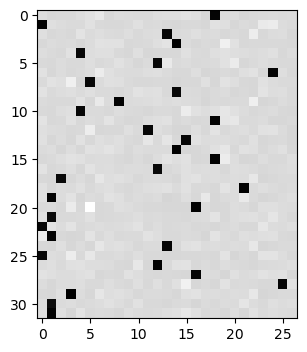

In [172]:
plt.figure(figsize=(4,4))
plt.imshow(dlogits.detach(), cmap='gray')

### Exercise 3: 
backprop through batchnorm but all in one go to complete this challenge look at the mathematical expression of the output of batchnorm, take the derivative w.r.t. its input, simplify the expression, and just write it out


In [173]:
hpreact_fast = bngain * (hprebn - hprebn.mean(0, keepdim=True)) / torch.sqrt(hprebn.var(0, keepdim=True, unbiased=True) + 1e-5) + bnbias
print('max diff:', (hpreact_fast - hpreact).abs().max().item())

max diff: 4.76837158203125e-07


In [174]:
dhprebn = bngain*bnvar_inv/n * (n*dhpreact - dhpreact.sum(0) - n/(n-1)*bnraw*(dhpreact*bnraw).sum(0))
cmp('hprebn', dhprebn, hprebn)

hprebn          | exact: False | approximate: True  | maxdiff: 4.656612873077393e-10


### Excercise 4:
Train the MLP

In [181]:
# checking values
batch_size, n, Xb.shape, Yb.shape

(32, 32, torch.Size([32, 3]), torch.Size([32]))

In [185]:
max_steps = 200000
lossi = []

with torch.no_grad():
    for i in range(max_steps):
        ix = torch.randint(1, Xtr.shape[0], (batch_size, ), generator=g)
        Xb, Yb = Xtr[ix], Ytr[ix]
        
        # FORWARD PASS
        emb = C[Xb]
        embcat = emb.view(emb.shape[0], -1)
        # Linear Layer
        hprebn = embcat @ W1 + b1
        # Batch Layer
        bnmean = hprebn.mean(0, keepdim=True)
        bnvar = hprebn.var(0, keepdim=True, unbiased=True)
        bnvar_inv = (bnvar + 1e-5)**-0.5
        bnraw = (hprebn - bnmean) * bnvar_inv
        hpreact = bngain * bnraw + bnbias
        # Non-linear Layer
        h = torch.tanh(hpreact)
        logits  = h @ W2 + b2
        loss = F.cross_entropy(logits, Yb)
        
        for p in parameters:
            p.grad = None
            
        # BACKWARD PASS
        dlogits = F.softmax(logits, 1)
        dlogits[range(n), Yb] -= 1
        dlogits /= n
        # 2nd layer backprop
        dh = dlogits @ W2.T
        dW2 = h.T @ dlogits
        db2 = dlogits.sum(0)
        dhpreact = (1.0 - h**2) * dh
        # batchnorm backprop
        dbngain = (bnraw * dhpreact).sum(0, keepdim=True)
        dbnbias = dhpreact.sum(0, keepdim=True)
        dhprebn = bngain*bnvar_inv/n * (n*dhpreact - dhpreact.sum(0) - n/(n-1)*bnraw*(dhpreact*bnraw).sum(0))
        # 1st layer
        dembcat = dhprebn @ W1.T
        dW1 = embcat.T @ dhprebn
        db1 = dhprebn.sum(0)
        # embedding
        demb = dembcat.view(emb.shape)
        dC = torch.zeros_like(C)
        for k in range(Xb.shape[0]):
            for j in range(Xb.shape[1]):
                ix = Xb[k,j]
                dC[ix] += demb[k,j]
        grads = [dC, dW1, db1, dW2, db2, dbngain, dbnbias]
        
        # update
        lr = 0.1 if i < 100000 else 0.01
        for p, grad in zip(parameters, grads):
            p.data += -lr * grad

        # track stats
        if i % 10000 == 0:
            print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
        lossi.append(loss.log10().item())

        

      0/ 200000: 3.5274
  10000/ 200000: 2.0417
  20000/ 200000: 2.7946
  30000/ 200000: 1.9108
  40000/ 200000: 2.1191
  50000/ 200000: 2.5233
  60000/ 200000: 2.2900
  70000/ 200000: 2.7653
  80000/ 200000: 1.8082
  90000/ 200000: 2.2928
 100000/ 200000: 2.2665
 110000/ 200000: 2.0573
 120000/ 200000: 2.2275
 130000/ 200000: 2.4528
 140000/ 200000: 2.1383
 150000/ 200000: 2.6044
 160000/ 200000: 2.2147
 170000/ 200000: 2.1267
 180000/ 200000: 2.3086
 190000/ 200000: 1.7960


In [205]:
with torch.no_grad():
    emb = C[Xtr]
    embcat = emb.view(emb.shape[0], -1)
    hpreact = embcat @ W1 + b1
    bnmean = hpreact.mean(0, keepdim=True)
    bnvar = hpreact.var(0, keepdim=True, unbiased=True)

In [207]:
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
    x,y = {
    'train': (Xtr, Ytr),
    'val': (Xval, Yval),
    'test': (Xtst, Ytst),
    }[split]
    emb = C[x] # (N, block_size, n_embd)
    embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
    hpreact = embcat @ W1 + b1
    hpreact = bngain * (hpreact - bnmean) * (bnvar + 1e-5)**-0.5 + bnbias
    h = torch.tanh(hpreact) # (N, n_hidden)
    logits = h @ W2 + b2 # (N, vocab_size)
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.146341323852539
val 2.170114517211914


In [209]:
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    out = []
    context = [0] * block_size
    while True:
        emb = C[torch.tensor([context])] # (1,block_size,d)      
        embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
        hpreact = embcat @ W1 + b1
        hpreact = bngain * (hpreact - bnmean) * (bnvar + 1e-5)**-0.5 + bnbias
        h = torch.tanh(hpreact) # (N, n_hidden)
        logits = h @ W2 + b2 # (N, vocab_size)

        # Sample
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        context = context[1:] + [ix]
        out.append(ix)
        if ix == 0:
            break
    
    print(''.join(itos[i] for i in out))

mria.
kayah.
see.
mad.
ryla.
reverstendraeg.
aden.
daelin.
shi.
jen.
edelieson.
arleitzion.
kalin.
shabergahiriel.
kindreeller.
nohulanu.
zayven.
kylynn.
eha.
kayshuston.
